In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

import mpmath as mp
import math

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import pandas as pd
from scipy import stats
import scipy
from scipy.optimize import minimize
from numpy import linalg as LA

import LGF_funcs as LGF
import time

In [107]:
def CompC(c, alpha = 0.5, n_max = 100, m_max = 100, eps = 1e-12):
    print("c = ", c)

    n_samples = n_max*m_max


    bessel_vec = np.zeros(n_samples)
    trap_vec = np.zeros(n_samples)
    fft_vec = np.zeros(n_samples)
    trap_true_vec = np.zeros(n_samples)

    # Compute true values
    t0 = time.time()
    for i in range(n_samples):
        m = int(i/n_max)
        n = i - m*n_max

        eta_n = c**2/alpha * (1 - 0.01)**2
        M_eta_n = 1/2/np.sqrt(c**2/alpha - eta_n)
        gamma_eta_n = np.log(1 + eta_n/2 + np.sqrt((1 + eta_n/2)**2 - 1))

        N_trap = int(math.ceil(1./gamma_eta_n*np.log(2*M_eta_n/eps)) + n)

        #trap_true_vec[i] = eval_lgf(c, alpha, n, m, N_trap*10)
        trap_true_vec[i] = LGF.eval_lgf(c, alpha, n, m, N_trap*2)
        #trap_true_vec[i] = eval_lgf_appell(c, n, m, alpha)
    t1 = time.time()
    t_true = t1 - t0

    print(t_true)
    print(trap_true_vec[0])

    # Compute trapezoidal rule values
    trap_n_times = 10
    t0 = time.time()
    for j in range(trap_n_times):
        for i in range(n_samples):
            m = int(i/n_max)
            n = i - m*n_max

            eta_n = c**2/alpha * (1 - 0.01)**2
            M_eta_n = 1/2/np.sqrt(c**2/alpha - eta_n)
            gamma_eta_n = np.log(1 + eta_n/2 + np.sqrt((1 + eta_n/2)**2 - 1))

            N_trap = int(math.ceil(1./gamma_eta_n*np.log(2*M_eta_n/eps)) + n)
            

            trap_vec[i] = LGF.eval_lgf(c, alpha, n, m, N_trap)

    t1 = time.time()
    t_trap = (t1 - t0)/trap_n_times

    # Compute FFT trapezoidal rule values
    fft_n_times = 1000
    t0 = time.time()
    for j in range(fft_n_times):
        for i in range(m_max):
            m = i
            idx_begin = i*n_max

            eta_n = c**2/alpha * (1 - 0.01)**2
            M_eta_n = 1/2/np.sqrt(c**2/alpha - eta_n)
            gamma_eta_n = np.log(1 + eta_n/2 + np.sqrt((1 + eta_n/2)**2 - 1))

            #N_trap1 = int(math.ceil(0.5/gamma_eta_n*np.log(2*M_eta_n/eps)))
            N_trap = max(int(n_max),int(math.ceil(0.5/gamma_eta_n*np.log(2*M_eta_n/eps)) + n_max/2))
            
            res = LGF.eval_lgf_rfft(c, alpha, m, N_trap)
            fft_vec[idx_begin:(idx_begin+n_max)] = res[:n_max]

    t1 = time.time()
    t_fft = (t1 - t0)/fft_n_times


    t0 = time.time()
    for i in range(n_samples):
        m = int(i/n_max)
        n = i - m*n_max

        eta_n = c**2/alpha * (1 - 0.01)**2
        M_eta_n = 1/2/np.sqrt(c**2/alpha - eta_n)
        gamma_eta_n = np.log(1 + eta_n/2 + np.sqrt((1 + eta_n/2)**2 - 1))

        N_trap = int(math.ceil(1./gamma_eta_n*np.log(2*M_eta_n/eps)) + n)
        

    t1 = time.time()
    t_non = t1 - t0


    t0 = time.time()
    for i in range(n_samples):
        m = int(i/n_max)
        n = i - m*n_max
        #res = Bessel_representation4(c, n, m, alpha, v, eps, 1000000000)
        res = LGF.Bessel_representation4(c, n, m, alpha, np.Infinity, eps, 1000000000)
        bessel_vec[i] = res
    t1 = time.time()
    bessel_t = t1 - t0

    bessel_inf = np.max(np.abs(bessel_vec - trap_true_vec))
    fft_inf = np.max(np.abs(fft_vec - trap_true_vec))
    trap_inf = np.max(np.abs(trap_vec - trap_true_vec))

    return t_trap, bessel_t, t_fft, trap_inf, bessel_inf, fft_inf

In [108]:
c_vec = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
err_fft_vec = np.zeros(len(c_vec))
err_trap_vec = np.zeros(len(c_vec))
err_bessel_vec = np.zeros(len(c_vec))
t_fft_vec = np.zeros(len(c_vec))
t_trap_vec = np.zeros(len(c_vec))
t_bessel_vec = np.zeros(len(c_vec))
for i, v in enumerate(c_vec):
    t_trap, bessel_t, t_fft, trap_inf, bessel_inf, fft_inf = CompC(v, 1)
    err_fft_vec[i] = fft_inf
    err_trap_vec[i] = trap_inf
    err_bessel_vec[i] = bessel_inf
    t_fft_vec[i] = t_fft
    t_trap_vec[i] = t_trap
    t_bessel_vec[i] = bessel_t

c =  0.001
13.743142127990723
1.3751977365500976


/Users/weihou/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/Caltech/TurbulentFlows/Helm_solver_paper/LGFPaper/LGF_funcs.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res = scipy.integrate.quad(lambda x: np.exp(-c**2*x)*scipy.special.ive(n,2*alpha*x)*scipy.special.ive(m,2*x), 0, x_up, epsrel=-1, epsabs=eps, limit = limits)


c =  0.002
6.5167341232299805
1.2648795057813693
c =  0.005
2.7120020389556885
1.1190446508140315
c =  0.01
1.4174489974975586
1.0087184848375876
c =  0.02
0.7821760177612305
0.8983713597117857
c =  0.05
0.43067121505737305
0.752369864620285
c =  0.1
0.31732892990112305
0.6415599786677033
c =  0.2
0.259443998336792
0.5296957186292073
c =  0.5
0.22581815719604492
0.3768552717693773


[0 1]


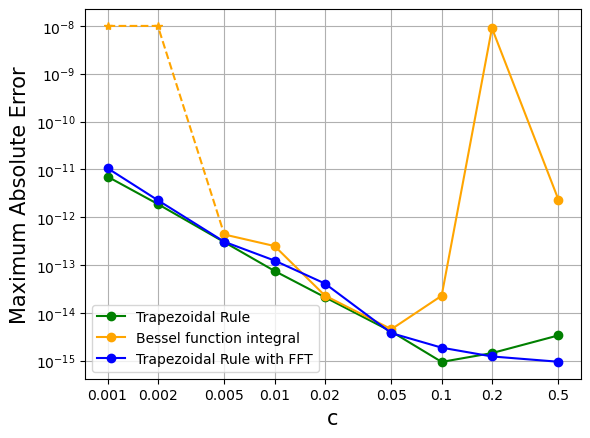

In [114]:
plt.clf()
plt.loglog(c_vec, err_trap_vec, '-o', c = 'g', label = "Trapezoidal Rule")
plt.loglog(c_vec, err_bessel_vec, '-o', c = 'orange', label = "Bessel function integral")
plt.loglog(c_vec, err_fft_vec, '-o', c = 'b', label = "Trapezoidal Rule with FFT")
nan_pos = 1e-8
nan_loc = np.array(np.where(np.isnan(err_bessel_vec))[0])
print(nan_loc)
c_nan = np.array(c_vec)[nan_loc]
n_c_nan = len(c_nan)
c_nan_pos = np.zeros(len(c_nan))
c_nan_pos.fill(nan_pos)
c_nan=np.append(c_nan,c_vec[n_c_nan])
c_nan_pos = np.append(c_nan_pos, err_bessel_vec[n_c_nan])
plt.loglog(c_nan, c_nan_pos, '--*', c = 'orange', label = "__nonlegend__")
plt.xticks(c_vec, c_vec)
plt.legend()
plt.grid(True)
plt.xlabel("c", fontsize = 15)
plt.ylabel("Maximum Absolute Error", fontsize = 15)
plt.minorticks_off()
plt.savefig("AcrossCBessel/c_error.pdf")

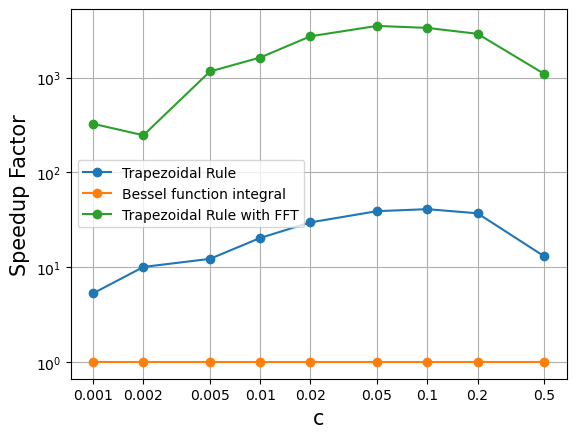

In [115]:
plt.clf()
plt.loglog(c_vec, t_bessel_vec/t_trap_vec, '-o', label = "Trapezoidal Rule")
plt.loglog(c_vec, t_bessel_vec/t_bessel_vec, '-o', label = "Bessel function integral")
plt.loglog(c_vec, t_bessel_vec/t_fft_vec, '-o', label = "Trapezoidal Rule with FFT")
plt.xticks(c_vec, c_vec)
plt.legend()
plt.xlabel("c", fontsize = 15)
plt.ylabel("Speedup Factor", fontsize = 15)
plt.grid(True)
plt.minorticks_off()
plt.savefig("AcrossCBessel/c_runtime.pdf")

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

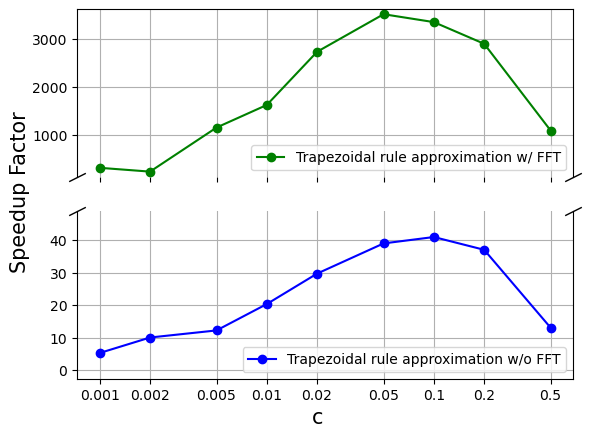

In [126]:
# Speed up using broken lines
plt.clf()
plt.figure()
#plt.semilogy(bessel_int_level_title, time_vec,'-o', label="Bessel function representation")
fft_speedup = t_bessel_vec/t_fft_vec
trap_speedup = t_bessel_vec/t_trap_vec
bessel_speedup = t_bessel_vec/t_bessel_vec

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.semilogx(c_vec, fft_speedup, '-o',color= 'g', label="Trapezoidal rule approximation w/ FFT")
ax2.semilogx(c_vec, trap_speedup, '-o',color = 'b', label="Trapezoidal rule approximation w/o FFT")
#ax3.semilogx(c_vec, bessel_speedup,'-o',color='r', label="Bessel function representation")

ax1.set_ylim(min(fft_speedup)-120, max(fft_speedup)+100)
ax2.set_ylim(min(trap_speedup)-8, max(trap_speedup)+8)
#ax3.set_ylim(min(bessel_speedup)-0.5, max(bessel_speedup)+0.5)

ax1.spines.bottom.set_visible(False)
#ax2.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
#ax3.spines.top.set_visible(False)

#ax1.xaxis.tick_top(False)
ax1.tick_params(labeltop=False, top=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
#ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
#ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.grid(visible = True, which='major')
ax2.grid(visible = True, which='major')
#ax3.grid(visible = True, which='major')

plt.xticks(c_vec, c_vec)

#plt.semilogy(bessel_int_level_title, trap_speedup, '-o', label="Trapezoidal rule approximation w/o FFT")
#plt.semilogy(bessel_int_level_title, fft_speedup, '-o', label="Trapezoidal rule approximation w/ FFT")
#plt.xticks(bessel_int_level_title, bessel_int_level)

#plt.semilogy(bessel_int_level_title, bessel_speedup,'-o', label="Bessel function representation")

#plt.axhline(y=t_trap, color='r', linestyle='-', label="Trapezoidal rule approximation w/o FFT")
#plt.axhline(y=t_fft, color='b', linestyle='--', label="Trapezoidal rule approximation w/ FFT")

#for i in range(len(bessel_int_level)):
#    if (~np.isnan(bessel_err[i])):
#        plt.text(bessel_int_level_title[i]-20000, time_vec[i]-0.8, "{:.2f}".format(time_vec[i]))
        #plt.text(bessel_int_level[i], bessel_err[i], str({}bessel_err[i]))

#plt.text(300000, t_trap+0.15, "{:.3f}".format(t_trap))
#plt.text(300000, t_fft+0.1, "{:.3f}".format(t_fft))

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
#ax3.legend(loc='lower right')
fig.supxlabel(r'c', fontsize=15)
fig.supylabel(r'Speedup Factor', fontsize=15)
#ax.set_yticks(np.logspace(-15, -2,14), minor=False)
#ax.set_yticks(np.logspace(-15, -2,141), minor=True)
plt.grid(visible = True, which='major')
#plt.grid(visible = True, which='minor', axis = 'both')

plt.minorticks_off()
#plt.show()
plt.savefig('AcrossCBessel/c_runtime_broken_line.pdf')